In [1]:
# Add source folder to path
import sys
sys.path.append("../src")

# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# scikit-learn 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Load scripts
from text_cleaning import clean_text
from clustering import KMeansAuthors, ModHausdorffDocument
from style_point_cloud import style_point_cloud
from multiauth_graph import doc_adjacency_matrix

# Progress bar
from tqdm import tqdm 
tqdm.pandas()

%load_ext autoreload
%autoreload 2

# Data load and preprocessing

In [2]:
df = pd.read_json("../data/csCL_sample.json")

# Text cleaning
df.text_body = df.text_body.progress_apply(clean_text)

# Generate point cloud for each text.
df["point_cloud"] = df.text_body.progress_apply(lambda text: style_point_cloud(text, window_size=600, window_overlap=300, max_tokens=15_000))

# Remove documents with no points
df = df[df.point_cloud.apply(len) > 0].copy()

100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


In [3]:
# This subsample was taking by considering if Diptesh Kanojia, Hannes Westermann, or Bing Liu
# were among the first 2 authors, so let just first use them as sole authors. 
author_list = ["Diptesh Kanojia", "Hannes Westermann", "Bing Liu"]
df["author_single"] = df.authors.apply(lambda x: set(x).intersection(author_list).pop())

# Create an author label for each point
auth_labels = [[author]*n_chunks for author, n_chunks in 
                zip(df.author_single, df.point_cloud.apply(len))]

# Flatten
auth_labels = [x for y in auth_labels for x in y]

# Method 1

Simple K-Means and identify clusters

In [121]:
data = StandardScaler().fit_transform(np.vstack(df.point_cloud))
X = PCA(n_components=3).fit_transform(data)

cl = KMeansAuthors(n_authors=3)

In [117]:
# Fit data. Pass author labels to assign one author per cluster
cl.fit(X, auth_labels)

In [118]:
# Metrics
author_pred = cl.predict_document(X, df.point_cloud.apply(len).to_numpy())
print(classification_report(y_true = df.author_single, y_pred = author_pred, zero_division=0))

                   precision    recall  f1-score   support

         Bing Liu       1.00      0.40      0.57         5
  Diptesh Kanojia       0.50      0.60      0.55         5
Hannes Westermann       0.17      0.25      0.20         4

         accuracy                           0.43        14
        macro avg       0.56      0.42      0.44        14
     weighted avg       0.58      0.43      0.46        14



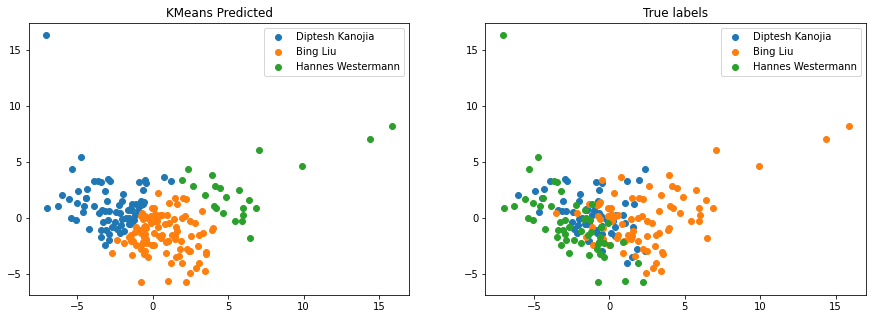

In [108]:
# Since we are doing PCA, let's have a look at some visualizations
predictions = cl.predict(X, author_labels=True)
auth_idx = dict(zip(set(predictions), range(len(set(predictions)))))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for label in set(predictions): 
    mask_pred = [True if pr == label else False for pr in predictions]
    mask_true = [True if pr == label else False for pr in auth_labels]
    ax1.scatter(X[:, 0][mask_pred], X[:, 1][mask_pred], label=label)
    ax2.scatter(X[:, 0][mask_true], X[:, 1][mask_true], label=label)
    ax1.legend()
    ax2.legend()
    ax1.set_title("KMeans Predicted")
    ax2.set_title("True labels")

While it can be some sort of separation in the concentration of points by looking at the true labels plot between _Bing Liu_ and the other two, this still is not too K-Means friendly, as can clearly be seen in the predicted labels--and even clearer in the metrics above.

# Method 2

Treat each style vector vector as a point and build a point cloud for each document. Then compute distances between them using a modified hausdorff distance and use, e.g., Agglomerative clustering from sklearn---or any other algorithm that admits a pre-computed metric and allow us to input the number of cluster. The latter is of course optional, one could simply run an algorithm that determines the number of clusters, but then it wouldn't be that visual to check the predictions as in this case. 

In [110]:
mhcl = ModHausdorffDocument(n_authors=3)
mhcl.fit(X, doc_lengths=df.point_cloud.apply(len).to_numpy(), author_labels=df.author_single)

In [113]:
# Metrics
author_pred = mhcl.predict_document()
print(classification_report(y_true = df.author_single, y_pred = author_pred, zero_division=0))

                   precision    recall  f1-score   support

         Bing Liu       1.00      0.20      0.33         5
  Diptesh Kanojia       0.56      1.00      0.71         5
Hannes Westermann       1.00      1.00      1.00         4

         accuracy                           0.71        14
        macro avg       0.85      0.73      0.68        14
     weighted avg       0.84      0.71      0.66        14



We definitely see an improvement with respect to the previous method. Though it is clear that half the _Diptesh Kanojia_ papers are classified as _Bing Liu_ ones, leaving a lot of room for improvement. However, we achieve a 70% of accuracy by this quick and simple method. 

# Multi-author information

For multi-author texts, different parts of the text will be written by different authors. We can explore this by, instead of using a point cloud for the whole document, as done above, we create several point clouds for fragments of each document, and explore how close these fragments are.

We can then create a graph linking the documents, where each edge would connect documents that share similar style---thus, potentially, similar author---in their fragments.

In [4]:
# Generate again the point clouds. This time with a bit more of
# overlap
df["point_cloud"] = df.text_body.progress_apply(lambda text:
 style_point_cloud(text, window_size=600, window_overlap=400, max_tokens=15_000))

100%|██████████| 14/14 [00:06<00:00,  2.14it/s]


In [5]:
# Create a sliding window to create point cloud of the 
# fragments. We also add here some overlap. 
frag_size = 6
overlap = 4

df.point_cloud = df.point_cloud.apply(lambda x: [x[i:i+frag_size] for i in
                                  range(0,
                                   len(x)-frag_size+overlap,
                                    frag_size-overlap)])

In [65]:
# Compute adjacency matrix
adj_matrix = doc_adjacency_matrix(df.point_cloud,
    method="closest",
    n_fragments=10,
    min_fragments=15)

{'Diptesh Kanojia': 'red', 'Hannes Westermann': 'lightblue', 'Bing Liu': 'green'}


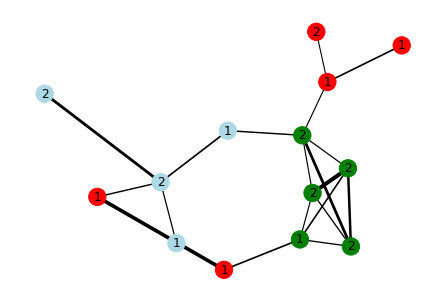

In [71]:
graph_auth = list(df.authors.apply(lambda x: set(x).intersection(author_list).pop()))
auth_col_dict = dict(zip(set(graph_auth), "red lightblue green".split()))
n_auth = [auth_list.index(auth) + 1 for auth_list, auth in zip(df.authors, graph_auth)]
graph_auth_col = [auth_col_dict[ath] for ath in graph_auth]

G = nx.Graph(adj_matrix)
widths = np.array(list(nx.get_edge_attributes(G, 'weight').values()))

nx.draw_kamada_kawai(G, node_color = graph_auth_col,
        width=4*widths/widths.max(), 
        labels = {i:ath for i, ath in zip(range(len(n_auth)), n_auth)})
print(auth_col_dict)

The width of the edge is proportional to the number of _closest fragments_ between documents, and the node number is the place in which the authors appear (either as a first or as a second author). 
Bing Liu's papers, appeared quite clustered and the links between these documents also seem to be quite strong. Diptesh Kanojia and Hannes Westermann appear a bit more mixed. For the former, we could in principle identify a region with three of his papers. For the latter, all their papers appear _close_ in the graph, but the links are in general not too strong. 